In [803]:
#Импорт всех необходимых библиотек
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pickle
from sklearn.model_selection import KFold
from scipy.stats import norm
from scipy import stats
import xgboost as xgb
import catboost
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import warnings
import copy
warnings.filterwarnings('ignore')
import re
import ast

In [804]:
data = pd.read_csv('data.csv')
top = ['WA', 'NH', 'MN', 'UT', 'VT', 'MD', 'VA', 'MA', 'NE', 'CO', 'WI', 'NJ', 'FL', 'IA', 'ND', 'ID']
mid = ['GA', 'NC', 'CA', 'SD', 'CT', 'KS', 'DE', 'HI', 'NY', 'RI', 'OR', 'MO', 'MT', 'TN', 'WY', 'ME']
    
data = data.drop(['MlsId', 'mls-id', 'private pool'],axis = 1)
def state(x):
    if x in top:
        return 2
    if x in mid:
        return 1
    return 0
    
def func_cool(x):
    if x == '':
        return 0
    return 1

def func_pool(x):
    if type(x) != int:
        x = x.replace(x, '1')
    return int(x)
    
def func_stor(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if (len(x) > 1):
            x = x[0]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return 1
    return x
    
def func_cost(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 2:
            x = x[0] + x[1] + x[2]
        elif len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)
    
def func_area(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)

def func_lot(x):
    if type(x) != int:
        x = re.findall(r'\d+',x)
        if len(x) > 1:
            x = x[0] + x[1]
        elif len(x) == 1:
            x = x[0]
        if not x:
            return np.nan
    return int(x)
    
def func_built(x):
    x = re.findall(r'\d+',x)
    if len(x) > 1:
        x = x[0] + x[1]
    elif len(x) == 1:
        x = x[0]
    if not x:
        return np.nan
    return int(x)
        
def data_func1(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][0].get('factValue')

def data_func2(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][1].get('factValue')

def data_func3(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][2].get('factValue')

def data_func4(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][3].get('factValue')

def data_func5(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][4].get('factValue')

def data_func6(x):
    a = ast.literal_eval(x)
    return a['atAGlanceFacts'][5].get('factValue')
    
def data_func8(x):
    m = []
    a = ast.literal_eval(x)
    a = dict(a[0])
    k = a['data'].get('Distance')
    for i in k:
        h = re.findall(r'\d+',i)
        if len(h) == 0:
            continue
        if len(h) == 1:
            m.append(float(h[0]))
            continue
        d = h[0] + '.' + h[1]
        m.append(float(d))
    if len(m) == 0:
        return np.nan
    else:
        return min(m)
    
def func_rebuilt(row):
    if row['rebuilt'] == 0:
        return row['built']
    if row['rebuilt'] == '':
        return row['built']
    return row['rebuilt']
 
data['PrivatePool'] = data['PrivatePool'].fillna(0).apply(func_pool)
data['fireplace'] = data['fireplace'].fillna(0).apply(func_pool)
data['baths'] = data['baths'].fillna(1).apply(func_stor)
data['stories'] = data['stories'].fillna(1).apply(func_stor)
data['beds'] = data['beds'].fillna(1).apply(func_stor)
data['built'] = data['homeFacts'].apply(data_func1)
data['rebuilt'] = data['homeFacts'].apply(data_func2)
data['heating'] = data['homeFacts'].apply(data_func3)
data['cooling'] = data['homeFacts'].apply(data_func4)
data['parking'] = data['homeFacts'].apply(data_func5)
data['lotsize'] = data['homeFacts'].apply(data_func6)
data['distance'] = data['schools'].apply(data_func8)
data = data.drop(['homeFacts', 'schools'], axis = 1)
data['cooling'] = data['cooling'].apply(func_cool)
data['heating'] = data['heating'].apply(func_cool)
data['parking'] = data['parking'].apply(func_cool)
data['state'] = data['state'].apply(state)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data['lotsize'] = data['lotsize'].apply(func_lot)
data = data.drop(data.loc[data['lotsize'].isnull()].index)
data = data.drop(data.loc[data['built'].isnull()].index)
data['built'] = data['built'].apply(func_built)
data = data.drop(data.loc[data['built'].isnull()].index)
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)
data['sqft'] = data['sqft'].apply(func_area)
data['target'] = data['target'].apply(func_cost)
data = data.drop(data.loc[data['target'].isnull()].index)
data = data.drop(data.loc[data['sqft'].isnull()].index)
data['rebuilt'] = data['rebuilt'].fillna(0)
data = data.drop(data.loc[data['distance'].isnull()].index)
data = data.drop(data.loc[data['city'].isnull()].index)
data = data.drop(data.loc[data['street'].isnull()].index)
data['rebuilt'] = data.apply(lambda row: func_rebuilt(row), axis=1)
data.to_csv('obr.csv', index=False)

In [805]:
data = pd.read_csv('obr.csv')

In [806]:
data['built'] = data['built'].astype(int)
data['rebuilt'] = data['rebuilt'].astype(int)
data['lotsize'] = data['lotsize'].astype(int)
data['sqft'] = data['sqft'].astype(int)
data = data.drop(['PrivatePool', 'heating', 'cooling', 'parking'], axis = 1)

In [807]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
categorical_columns = []
features = data.columns.values.tolist()
for col in features:
    if data[col].dtype in numerics: continue
    categorical_columns.append(col)
for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        le.fit(list(data[col].astype(str).values))
        data[col] = le.transform(list(data[col].astype(str).values))

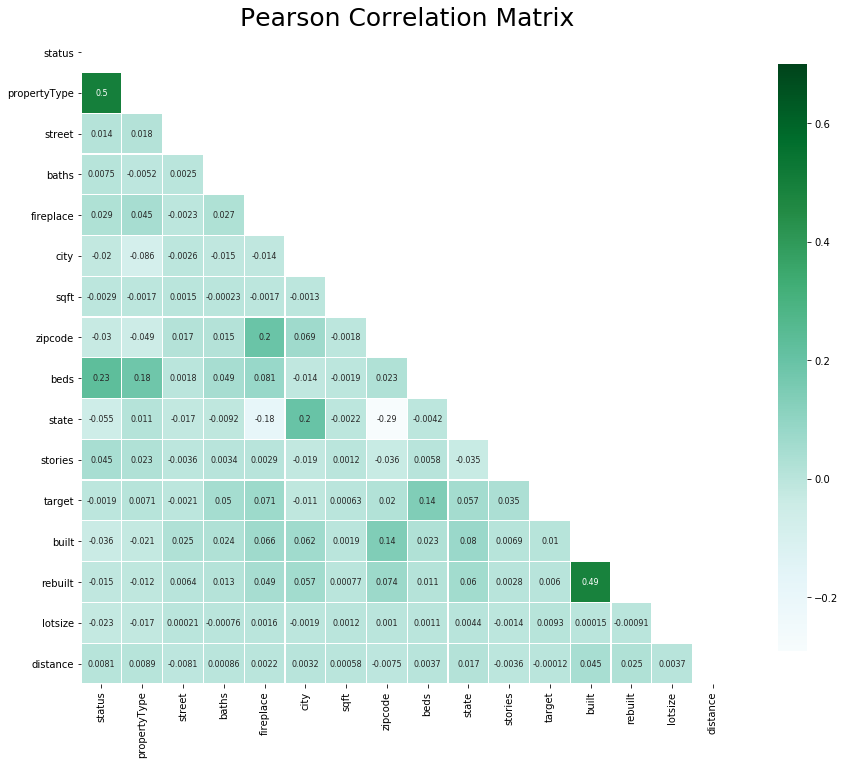

In [810]:
mask = np.zeros_like(data[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(data[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

In [811]:
data.describe(percentiles=[.01, .02, .03, .05, .1, .5, .9, .92, .94, .98, .99])

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,stories,target,built,rebuilt,lotsize,distance
count,"236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00","236,708.00"
mean,97.36,877.23,"104,120.62",2.64,0.38,817.65,"4,938.86","2,023.17",3.09,0.94,1.49,"630,832.03","1,976.45","1,980.11","16,377.04",1.08
std,56.38,164.32,"60,090.22",11.61,0.49,440.98,"938,603.40","1,044.89",2.26,0.86,3.46,"1,637,490.75",34.30,57.08,"727,862.81",6.53
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00
1%,4.00,77.00,"1,978.07",1.00,0.00,50.07,570.00,101.00,1.00,0.00,0.00,"24,000.00","1,897.00","1,900.00",3.00,0.10
2%,4.00,286.00,"4,064.14",1.00,0.00,66.00,707.00,164.00,1.00,0.00,0.00,"40,000.00","1,900.00","1,905.00",6.00,0.10
3%,4.00,343.00,"6,131.21",1.00,0.00,71.00,780.00,189.00,1.00,0.00,0.00,"55,000.00","1,909.00","1,911.00",25.00,0.10
5%,4.00,461.00,"10,308.35",1.00,0.00,134.00,885.00,285.00,1.00,0.00,1.00,"79,900.00","1,916.00","1,920.00",27.00,0.14
10%,4.00,852.00,"20,751.70",1.00,0.00,261.00,"1,051.00",765.00,1.00,0.00,1.00,"127,259.00","1,925.00","1,931.00",34.00,0.20
50%,140.00,958.00,"104,379.50",2.00,0.00,770.00,"1,943.00","1,808.00",3.00,1.00,1.00,"338,999.50","1,982.00","1,988.00","5,000.00",0.60


In [812]:
data = data[data['sqft'] < 7100]
data = data[data['baths'] <= 8]
data = data[data['beds'] <= 7]
data = data[data['stories'] <= 6]
data = data[data['target'] <= 3500000]
data = data[data['built'] < 2020]
data = data[data['rebuilt'] < 2020]
data = data[data['lotsize'] <= 40000]
data = data[data['distance'] < 7]
data = data[data['built'] >= 1900]
data = data[data['rebuilt'] >= 1900]
data = data[data['street'] >= 4000]
data = data[data['city'] > 66]
data = data[data['sqft'] >= 700]
data = data[data['lotsize'] >= 6]
data = data[data['target'] >= 40000]
data = data[data['zipcode'] > 160]
data = data[data['beds'] >= 1]

In [814]:
train_fe = copy.deepcopy(data)
target_fe = train_fe['target']
del train_fe['target']
X = train_fe
z = target_fe
Xtrain, Xval, Ztrain, Zval = train_test_split(X, z, test_size=0.2, random_state=21)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelL = lgb.train(params, train_set = train_set, num_boost_round=1000,
                   early_stopping_rounds=50,verbose_eval=100, valid_sets=valid_set)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 244986
[200]	valid_0's rmse: 224955
[300]	valid_0's rmse: 216888
[400]	valid_0's rmse: 211372
[500]	valid_0's rmse: 206954
[600]	valid_0's rmse: 203755
[700]	valid_0's rmse: 201255
[800]	valid_0's rmse: 198927
[900]	valid_0's rmse: 196858
[1000]	valid_0's rmse: 195123
Did not meet early stopping. Best iteration is:
[999]	valid_0's rmse: 195121


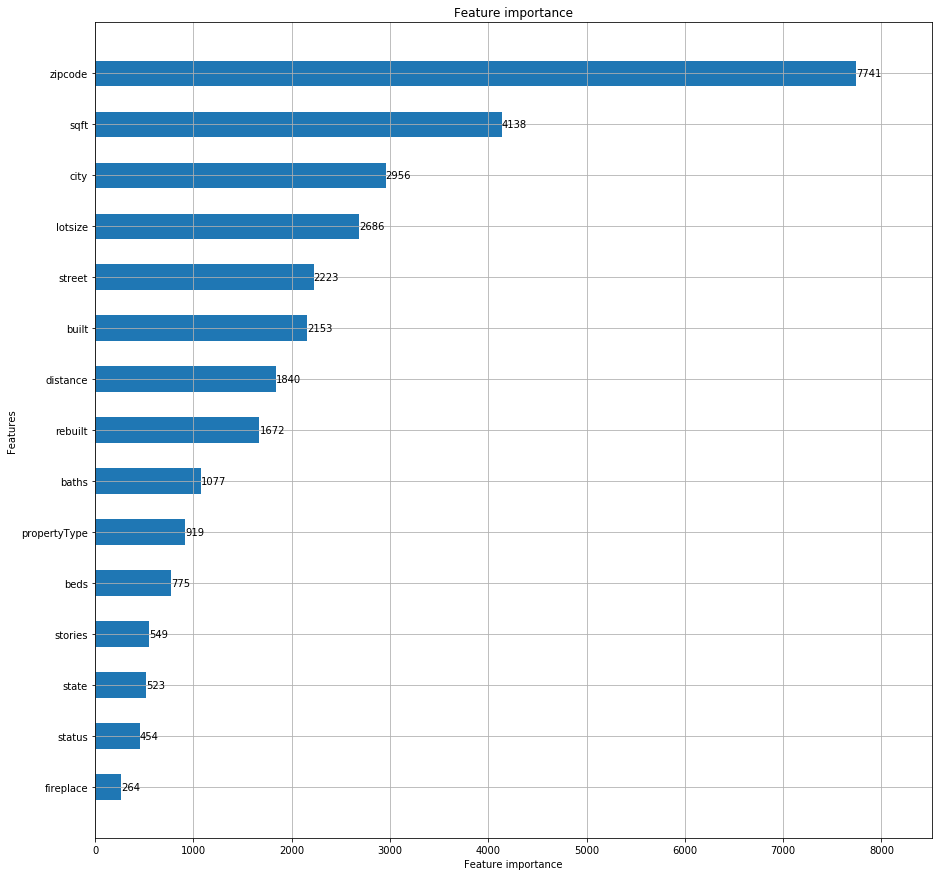

In [815]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();plt.close()

In [816]:
feature_score = pd.DataFrame(train_fe.columns, columns = ['feature']) 
feature_score['score_lgb'] = modelL.feature_importance()

In [817]:
data_tr  = xgb.DMatrix(Xtrain, label=Ztrain)
data_cv  = xgb.DMatrix(Xval   , label=Zval)
evallist = [(data_tr, 'train'), (data_cv, 'valid')]

In [818]:
parms = {'max_depth':8, #maximum depth of a tree
         'objective':'reg:squarederror',
         'eta'      :0.3,
         'subsample':0.8,#SGD will use this percentage of data
         'lambda '  :4, #L2 regularization term,>1 more conservative 
         'colsample_bytree ':0.9,
         'colsample_bylevel':1,
         'min_child_weight': 10}
modelx = xgb.train(parms, data_tr, num_boost_round=200, evals = evallist,
                  early_stopping_rounds=30, maximize=False, 
                  verbose_eval=10)

print('score = %1.5f, n_boost_round =%d.'%(modelx.best_score,modelx.best_iteration))

[21:41:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { colsample_bytree , lambda  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:510068.34375	valid-rmse:503186.87500
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 30 rounds.
[10]	train-rmse:226450.09375	valid-rmse:235169.01562
[20]	train-rmse:205320.12500	valid-rmse:221205.09375
[30]	train-rmse:193649.29688	valid-rmse:214897.64062
[40]	train-rmse:185607.71875	valid-rmse:210334.29688
[50]	train-rmse:179561.59375	valid-rmse:206877.70312
[60]	train-rmse:174469.09375	valid-rmse:205286.03125
[70]	train-rmse:169521.48438	valid-rmse:202990.15625
[80]	train-rmse:164460.28125

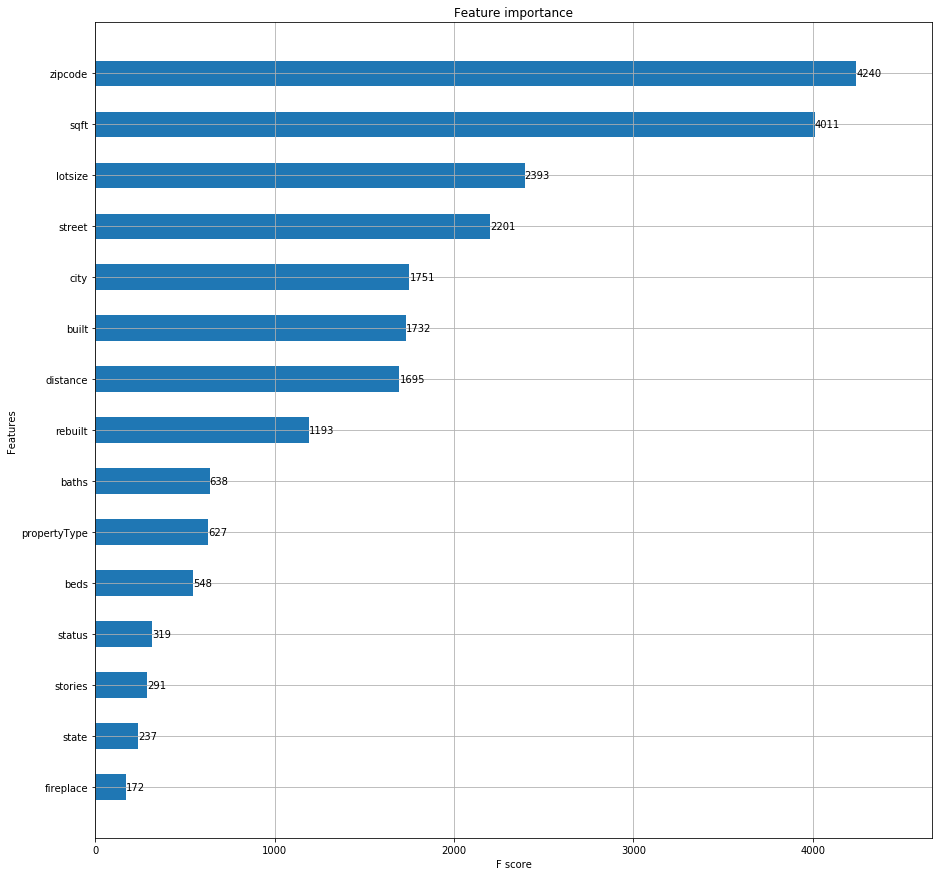

In [819]:
fig =  plt.figure(figsize = (15,15))
axes = fig.add_subplot(111)
xgb.plot_importance(modelx,ax = axes,height = 0.5)
plt.show();plt.close()

In [820]:
feature_score['score_xgb'] = feature_score['feature'].map(modelx.get_score(importance_type='weight'))
feature_score

,feature,score_lgb,score_xgb
0,status,454,319
1,propertyType,919,627
2,street,2223,2201
3,baths,1077,638
4,fireplace,264,172
5,city,2956,1751
6,sqft,4138,4011
7,zipcode,7741,4240
8,beds,775,548
9,state,523,237


In [821]:
linreg = LinearRegression()
linreg.fit(train_fe, target_fe)
coeff_linreg = pd.DataFrame(train_fe.columns.delete(0))
coeff_linreg.columns = ['feature']
coeff_linreg["score_linreg"] = pd.Series(linreg.coef_)
coeff_linreg.sort_values(by='score_linreg', ascending=False)

,feature,score_linreg
9,stories,"109,828.40"
3,fireplace,"106,029.86"
10,built,"7,332.74"
6,zipcode,237.15
7,beds,60.86
2,baths,-0.05
13,distance,-5.07
1,street,-15.11
5,sqft,-30.04
0,propertyType,-135.99


In [822]:
coeff_linreg["score_linreg"] = coeff_linreg["score_linreg"].abs().astype(int)
feature_score = pd.merge(feature_score, coeff_linreg, on='feature')
feature_score = feature_score.fillna(0)
feature_score = feature_score.set_index('feature')
feature_score

,score_lgb,score_xgb,score_linreg
feature,,,
propertyType,919,627,135
street,2223,2201,15
baths,1077,638,0
fireplace,264,172,106029
city,2956,1751,21789
sqft,4138,4011,30
zipcode,7741,4240,237
beds,775,548,60
state,523,237,56333


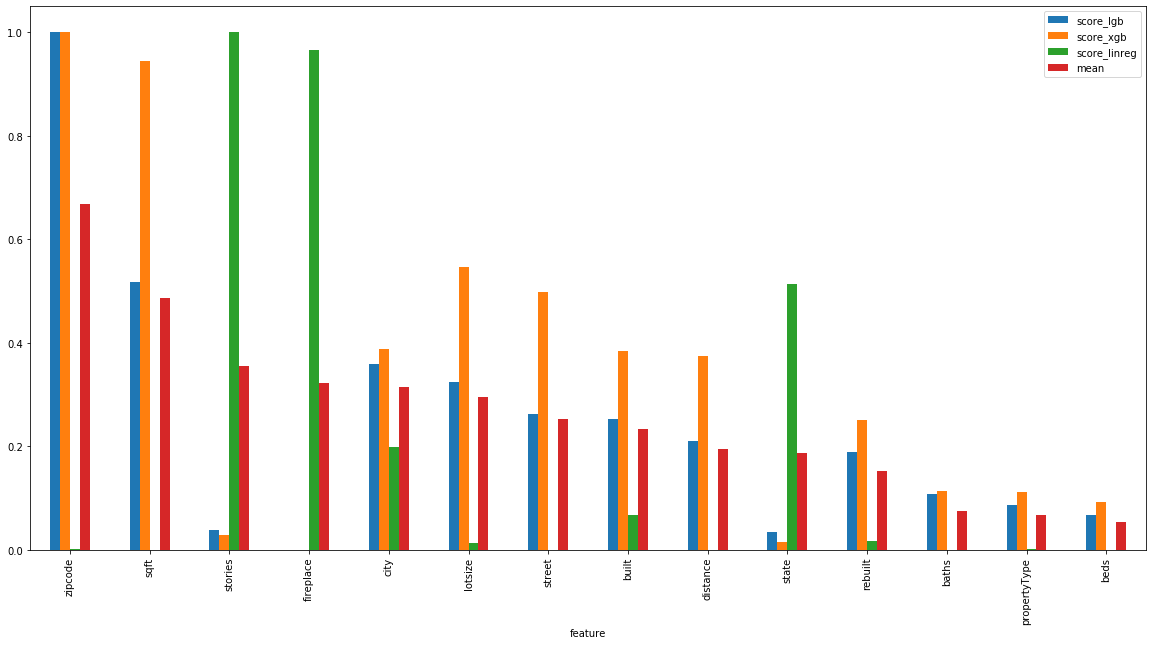

In [823]:
feature_score = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(feature_score),
    columns=feature_score.columns,
    index=feature_score.index
)

feature_score['mean'] = feature_score.mean(axis=1)

feature_score.sort_values('mean', ascending=False).plot(kind='bar', figsize=(20, 10))

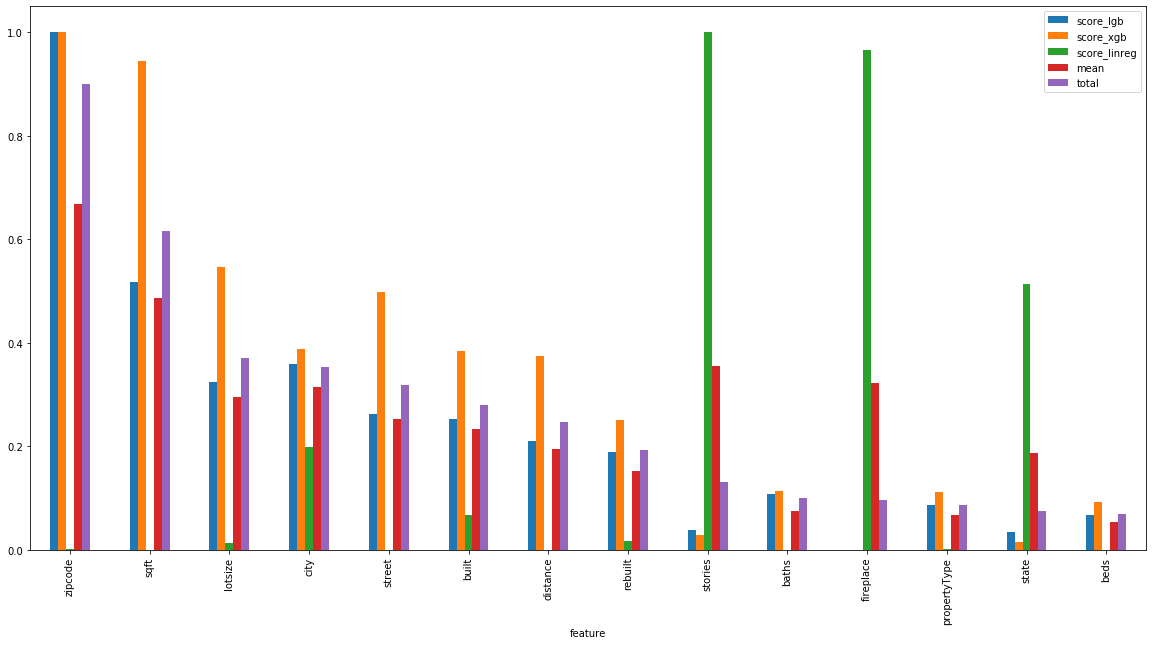

In [824]:
feature_score['total'] = 0.55*feature_score['score_lgb'] + 0.35*feature_score['score_xgb'] \
                       + 0.1*feature_score['score_linreg']

feature_score.sort_values('total', ascending=False).plot(kind='bar', figsize=(20, 10))

In [825]:
feature_score.sort_values('total', ascending=False)

,score_lgb,score_xgb,score_linreg,mean,total
feature,,,,,
zipcode,1.00,1.00,0.00,0.67,0.90
sqft,0.52,0.94,0.00,0.49,0.62
lotsize,0.32,0.55,0.01,0.29,0.37
city,0.36,0.39,0.20,0.32,0.35
street,0.26,0.50,0.00,0.25,0.32
built,0.25,0.38,0.07,0.23,0.28
distance,0.21,0.37,0.00,0.20,0.25
rebuilt,0.19,0.25,0.02,0.15,0.19
stories,0.04,0.03,1.00,0.36,0.13


In [826]:
valid_part = 0.3
target_name = 'target'
train_target0 = data[target_name]
train0 = data.drop([target_name], axis=1)
train0, test0, train_target0, test_target0 = train_test_split(train0, train_target0, test_size=0.2, random_state=0)
train0b = train0
train_target0b = train_target0
trainb, testb, targetb, target_testb = train_test_split(train0b, train_target0b, test_size=valid_part, random_state=0)
scaler = StandardScaler()
train0 = pd.DataFrame(scaler.fit_transform(train0), columns = train0.columns)
train, test, target, target_test = train_test_split(train0, train_target0, test_size=valid_part, random_state=0)

In [827]:
acc_train_r2 = []
acc_test_r2 = []
acc_train_d = []
acc_test_d = []
acc_train_rmse = []
acc_test_rmse = []
acc_train_mape = []
acc_test_mape = []

def acc_d(y_meas, y_pred):
    return mean_absolute_error(y_meas, y_pred)*len(y_meas)/sum(abs(y_meas))

def acc_rmse(y_meas, y_pred):
    return (mean_squared_error(y_meas, y_pred))**0.5

def acc_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def acc_boosting_model(num,model,train,test,num_iteration=0):
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse, acc_train_mape, acc_test_mape
    if num_iteration > 0:
        ytrain = model.predict(train, num_iteration = num_iteration)  
        ytest = model.predict(test, num_iteration = num_iteration)
    else:
        ytrain = model.predict(train)  
        ytest = model.predict(test)

    print('target = ', targetb[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(targetb, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)
    
    acc_train_mape_num = round(acc_mape(targetb, ytrain) * 100, 2)
    print('acc(mape) for train =', acc_train_mape_num)   
    acc_train_mape.insert(num, acc_train_mape_num)

    acc_train_d_num = round(acc_d(targetb, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(targetb, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_testb[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_testb, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)

    acc_test_mape_num = round(acc_mape(target_testb, ytest) * 100, 2)
    print('acc(mape) for test =', acc_test_mape_num)   
    acc_test_mape.insert(num, acc_test_mape_num)
    
    acc_test_d_num = round(acc_d(target_testb, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_testb, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [828]:
def acc_model(num,model,train,test):  
  
    global acc_train_r2, acc_test_r2, acc_train_d, acc_test_d, acc_train_rmse, acc_test_rmse, acc_train_mape, acc_test_mape
    
    ytrain = model.predict(train)  
    ytest = model.predict(test)

    print('target = ', target[:5].values)
    print('ytrain = ', ytrain[:5])

    acc_train_r2_num = round(r2_score(target, ytrain) * 100, 2)
    print('acc(r2_score) for train =', acc_train_r2_num)   
    acc_train_r2.insert(num, acc_train_r2_num)
    
    acc_train_mape_num = round(acc_mape(target, ytrain) * 100, 2)
    print('acc(mape) for train =', acc_train_mape_num)   
    acc_train_mape.insert(num, acc_train_mape_num)

    acc_train_d_num = round(acc_d(target, ytrain) * 100, 2)
    print('acc(relative error) for train =', acc_train_d_num)   
    acc_train_d.insert(num, acc_train_d_num)

    acc_train_rmse_num = round(acc_rmse(target, ytrain) * 100, 2)
    print('acc(rmse) for train =', acc_train_rmse_num)   
    acc_train_rmse.insert(num, acc_train_rmse_num)

    print('target_test =', target_test[:5].values)
    print('ytest =', ytest[:5])
    
    acc_test_r2_num = round(r2_score(target_test, ytest) * 100, 2)
    print('acc(r2_score) for test =', acc_test_r2_num)
    acc_test_r2.insert(num, acc_test_r2_num)
    
    acc_test_mape_num = round(acc_mape(target_test, ytest) * 100, 2)
    print('acc(mape) for test =', acc_test_mape_num)
    acc_test_mape.insert(num, acc_test_mape_num)
    
    acc_test_d_num = round(acc_d(target_test, ytest) * 100, 2)
    print('acc(relative error) for test =', acc_test_d_num)
    acc_test_d.insert(num, acc_test_d_num)
    
    acc_test_rmse_num = round(acc_rmse(target_test, ytest) * 100, 2)
    print('acc(rmse) for test =', acc_test_rmse_num)
    acc_test_rmse.insert(num, acc_test_rmse_num)

In [829]:
random_forest = RandomForestRegressor(n_estimators = 300, max_depth = 7, random_state = 21)
random_forest.fit(train, target)
acc_model(1,random_forest,train,test)

target =  [ 239000  374640  414995 1275000  275000]
ytrain =  [200507.2855369  420841.12238171 424452.21357235 934433.9359439
 361453.91452382]
acc(r2_score) for train = 63.64
acc(mape) for train = 47.52
acc(relative error) for train = 34.94
acc(rmse) for train = 28073679.02
target_test = [ 285000  256000  259000  355000 1674900]
ytest = [ 272612.24624421  443983.95682061  191156.78811239  574424.64490632
 1205245.42742647]
acc(r2_score) for test = 61.52
acc(mape) for test = 48.02
acc(relative error) for test = 35.49
acc(rmse) for test = 28686204.27


In [830]:
xgb_clf = xgb.XGBRegressor() 
parameters = {'n_estimators': [300], 
              'learning_rate': [0.1],
              'max_depth': [10],
              'reg_lambda': [0.5]}
xgb_reg = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1).fit(trainb, targetb)
print("Best score: %0.3f" % xgb_reg.best_score_)
print("Best parameters set:", xgb_reg.best_params_)
acc_boosting_model(2,xgb_reg,trainb,testb)

Best score: 0.816
Best parameters set: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_lambda': 0.5}
target =  [ 239000  374640  414995 1275000  275000]
ytrain =  [ 233023.34  389426.1   407797.6  1244170.1   263465.3 ]
acc(r2_score) for train = 97.17
acc(mape) for train = 15.55
acc(relative error) for train = 10.59
acc(rmse) for train = 7827862.1
target_test = [ 285000  256000  259000  355000 1674900]
ytest = [ 250331.23  367893.8   280601.66  391725.06 2211037.5 ]
acc(r2_score) for test = 82.8
acc(mape) for test = 23.86
acc(relative error) for test = 20.36
acc(rmse) for test = 19176078.92


In [831]:
Xtrain, Xval, Ztrain, Zval = train_test_split(trainb, targetb, test_size=0.2, random_state=0)
train_set = lgb.Dataset(Xtrain, Ztrain, silent=False)
valid_set = lgb.Dataset(Xval, Zval, silent=False)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 100,
        'learning_rate': 0.1,
        'max_bin' : 3000 ,
        'colsample_bytree': 0.9,
        'metric': 'rmse',
        'min_child_samples': 9,
        'zero_as_missing': False,
        'seed':0,        
    }
modelL = lgb.train(params, train_set = train_set, num_boost_round=10000,
                   early_stopping_rounds=8000,verbose_eval=1000, valid_sets=valid_set)

Training until validation scores don't improve for 8000 rounds
[1000]	valid_0's rmse: 188063
[2000]	valid_0's rmse: 186099
[3000]	valid_0's rmse: 185449
[4000]	valid_0's rmse: 185219
[5000]	valid_0's rmse: 185069
[6000]	valid_0's rmse: 184994
[7000]	valid_0's rmse: 184949
[8000]	valid_0's rmse: 184917
[9000]	valid_0's rmse: 184899
[10000]	valid_0's rmse: 184890
Did not meet early stopping. Best iteration is:
[9989]	valid_0's rmse: 184890


In [832]:
acc_boosting_model(3,modelL,trainb,testb,modelL.best_iteration)

target =  [ 239000  374640  414995 1275000  275000]
ytrain =  [ 242002.07948339  374088.60460769  414990.85553464 1093495.72189225
  277980.92946085]
acc(r2_score) for train = 96.84
acc(mape) for train = 4.9
acc(relative error) for train = 4.1
acc(rmse) for train = 8272374.23
target_test = [ 285000  256000  259000  355000 1674900]
ytest = [ 253910.62992577  360679.68829212  294572.19534504  333093.72135283
 2096473.96520502]
acc(r2_score) for test = 83.86
acc(mape) for test = 22.27
acc(relative error) for test = 19.29
acc(rmse) for test = 18576852.02


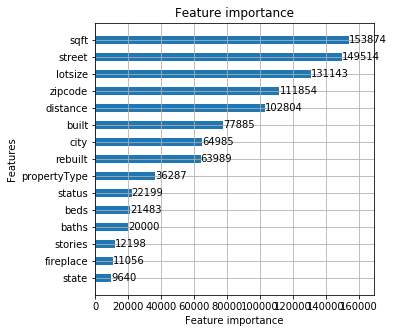

In [833]:
fig =  plt.figure(figsize = (5,5))
axes = fig.add_subplot(111)
lgb.plot_importance(modelL,ax = axes,height = 0.5)
plt.show();
plt.close()

In [834]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'XGB', 'LGBM'],
    
    'r2_train': acc_train_r2,
    'r2_test': acc_test_r2,
    'mape_train': acc_train_mape,
    'mape_test': acc_test_mape,
    'd_train': acc_train_d,
    'd_test': acc_test_d,
    'rmse_train': acc_train_rmse,
    'rmse_test': acc_test_rmse
                     })

In [835]:
print('Prediction accuracy for models by different metrics')
models.sort_values(by=['mape_test', 'mape_train'], ascending=False)

Prediction accuracy for models by different metrics


,Model,r2_train,r2_test,mape_train,mape_test,d_train,d_test,rmse_train,rmse_test
0,Random Forest,63.64,61.52,47.52,48.02,34.94,35.49,"28,073,679.02","28,686,204.27"
1,XGB,97.17,82.80,15.55,23.86,10.59,20.36,"7,827,862.10","19,176,078.92"
2,LGBM,96.84,83.86,4.90,22.27,4.10,19.29,"8,272,374.23","18,576,852.02"


In [836]:
lgb_predict = modelL.predict(test0)

In [837]:
final_df = test_target0.values
final_df = pd.DataFrame(final_df,columns=['Real_price'])
for x in range(len(lgb_predict)):
    lgb_predict[x] = round(lgb_predict[x]/1000)*1000
final_df['predicted_prices'] = lgb_predict.astype(int)
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int)
final_df.head(10)

,Real_price,predicted_prices,difference
0,234700,285000,50300
1,89000,117000,28000
2,229999,252000,22001
3,545000,499000,46000
4,420000,487000,67000
5,250000,211000,39000
6,485000,395000,90000
7,1279000,1508000,229000
8,559000,1236000,677000
9,247365,151000,96365


In [838]:
def acc_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [839]:
print(acc_mape(test_target0, lgb_predict))

22.85117921764857


In [786]:
import pickle
with open('mymodel.pkl', 'wb') as output:
       pickle.dump(modelL, output)